Import of all dependencies

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import gym
import torch.nn as nn

Define DQN 

In [8]:
class DQN(nn.Module):
    """
    Deep Q-Network module.

    Args:
        in_states (int): Number of input states.
        h1_nodes (int): Number of nodes in the first hidden layer.
        h2_nodes (int): Number of nodes in the second hidden layer.
        out_actions (int): Number of output actions.
    """
    def __init__(self, in_states, h1_nodes, h2_nodes, out_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes, h2_nodes)
        self.fc3 = nn.Linear(h2_nodes, out_actions)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayMemory:
    """
    Replay Memory class for storing and sampling transitions.

    Args:
        capacity (int): Maximum number of transitions to store in memory.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def append(self, transition):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

Implementation of Frozenlake via OpenAI gym

In [9]:
class FrozenLakeDQL:
    """
    A Deep Q-Learning implementation for the FrozenLake-v1 environment.
    """
    
    learning_rate_a = 0.0001
    discount_factor_g = 0.99
    network_sync_rate = 20
    replay_memory_size = 5000
    mini_batch_size = 128

    loss_fn = nn.MSELoss()
    optimizer = None

    ACTIONS = ['L', 'D', 'R', 'U']

    def __init__(self):
        """
        Initialize the FrozenLakeDQL class.
        """
        self.success_list = []

    def test(self, episodes, is_slippery=False):
        """
        Test the trained DQN model on the FrozenLake environment.

        Args:
            episodes (int): Number of episodes to test.
            is_slippery (bool): Whether the environment is slippery or not.
        """
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load the trained policy DQN model
        policy_dqn = DQN(in_states=num_states, h1_nodes=128, h2_nodes=128, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False

            while not terminated and not truncated:
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                state, reward, terminated, truncated, _ = env.step(action)

        env.close()

    def print_dqn(self, dqn):
        """
        Print the Q-values and best actions for each state in the DQN model.

        Args:
            dqn (DQN): The DQN model to print.
        """
        num_states = dqn.fc1.in_features

        for s in range(num_states):
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q) + ' '
            q_values = q_values.rstrip()
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]
            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s + 1) % 4 == 0:
                print()

    def train(self, episodes, render=False, is_slippery=False):
        """
        Train the DQN model on the FrozenLake environment.

        Args:
            episodes (int): Number of episodes to train.
            render (bool): Whether to render the environment during training.
            is_slippery (bool): Whether the environment is slippery or not.
        """
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        epsilon = 1
        min_epsilon = 0.01
        decay_rate = 0.0005
        memory = ReplayMemory(self.replay_memory_size)

        # Initialize policy and target DQNs
        policy_dqn = DQN(in_states=num_states, h1_nodes=128, h2_nodes=128, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=128, h2_nodes=128, out_actions=num_actions)

        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = np.zeros(episodes)
        episode_lengths = np.zeros(episodes)
        losses = []
        epsilon_history = []
        q_values_history = []

        step_count = 0

        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False
            episode_length = 0

            while not terminated and not truncated:
                # Epsilon-greedy action selection
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                new_state, reward, terminated, truncated, _ = env.step(action)
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                episode_length += 1
                step_count += 1

            episode_lengths[i] = episode_length

            if reward == 1:
                rewards_per_episode[i] = 1
                self.success_list.append(1)
            else:
                self.success_list.append(0)

            q_values_history.append(policy_dqn(self.state_to_dqn_input(0, num_states)).detach().numpy())

            # Optimize the policy DQN using mini-batches from replay memory
            if len(memory) > self.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.mini_batch_size)
                loss = self.optimize(mini_batch, policy_dqn, target_dqn)
                losses.append(loss.item())

                # Update epsilon
                epsilon = min_epsilon + (1 - min_epsilon) * np.exp(-decay_rate * i)
                epsilon_history.append(epsilon)

                # Sync target DQN with policy DQN
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        env.close()

        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")
        self.plot_training_results(episodes, rewards_per_episode, epsilon_history, episode_lengths, losses, q_values_history, policy_dqn, env)

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        """
        Optimize the policy DQN using a mini-batch of experiences.

        Args:
            mini_batch (list): Mini-batch of experiences.
            policy_dqn (DQN): The policy DQN model.
            target_dqn (DQN): The target DQN model.

        Returns:
            torch.Tensor: The computed loss.
        """
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            target_q[action] = target
            target_q_list.append(target_q)

        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

    def state_to_dqn_input(self, state: int, num_states: int) -> torch.Tensor:
        """
        Convert a state to a DQN input tensor.

        Args:
            state (int): The state to convert.
            num_states (int): Total number of states.

        Returns:
            torch.Tensor: The DQN input tensor.
        """
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    def plot_training_results(self, episodes, rewards_per_episode, epsilon_history, episode_lengths, losses, q_values_history, policy_dqn, env):
        """
        Plot the training results.

        Args:
            episodes (int): Number of episodes.
            rewards_per_episode (np.ndarray): Rewards per episode.
            epsilon_history (list): Epsilon values per episode.
            episode_lengths (np.ndarray): Lengths of episodes.
            losses (list): Loss values per episode.
            q_values_history (list): Q-values history.
            policy_dqn (DQN): The policy DQN model.
            env (gym.Env): The environment.
        """
        plt.figure(figsize=(14, 10))

        # Plot cumulative rewards
        plt.subplot(231)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x - 100):(x + 1)])
        plt.plot(sum_rewards)
        plt.title('Cumulative Rewards')
        plt.xlabel('Episodes')
        plt.ylabel('Cumulative Reward')

        # Plot epsilon decay
        plt.subplot(232)
        plt.plot(epsilon_history)
        plt.title('Epsilon Decay')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')

        # Plot loss values
        plt.subplot(234)
        plt.plot(losses)
        plt.title('Loss Values')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')

        # Plot success rate
        plt.subplot(235)
        success_rate = np.cumsum(self.success_list) / (np.arange(1, len(self.success_list) + 1))
        plt.plot(success_rate)
        plt.title('Success Rate')
        plt.xlabel('Episodes')
        plt.ylabel('Success Rate')

        plt.tight_layout()
        plt.savefig('frozen_lake_dql_metrics.png')
        plt.show()
    



Trains and evaluates the DQN

Policy (random, before training):
00,D,[-0.03 +0.06 +0.04 +0.01] 01,D,[-0.08 +0.06 +0.05 +0.03] 02,R,[-0.03 +0.03 +0.04 +0.04] 03,D,[-0.03 +0.03 +0.02 +0.02] 
04,R,[+0.01 +0.05 +0.08 +0.00] 05,R,[-0.02 +0.02 +0.03 -0.02] 06,R,[-0.06 +0.05 +0.07 +0.01] 07,R,[-0.06 +0.05 +0.06 +0.05] 
08,R,[-0.07 +0.01 +0.06 +0.01] 09,R,[-0.03 +0.00 +0.05 +0.02] 10,U,[-0.06 +0.03 +0.03 +0.04] 11,D,[-0.04 +0.03 +0.03 +0.01] 
12,R,[-0.04 +0.02 +0.06 +0.05] 13,R,[-0.02 -0.01 +0.01 +0.00] 14,R,[-0.03 +0.03 +0.05 -0.00] 15,R,[-0.06 +0.01 +0.06 -0.00] 


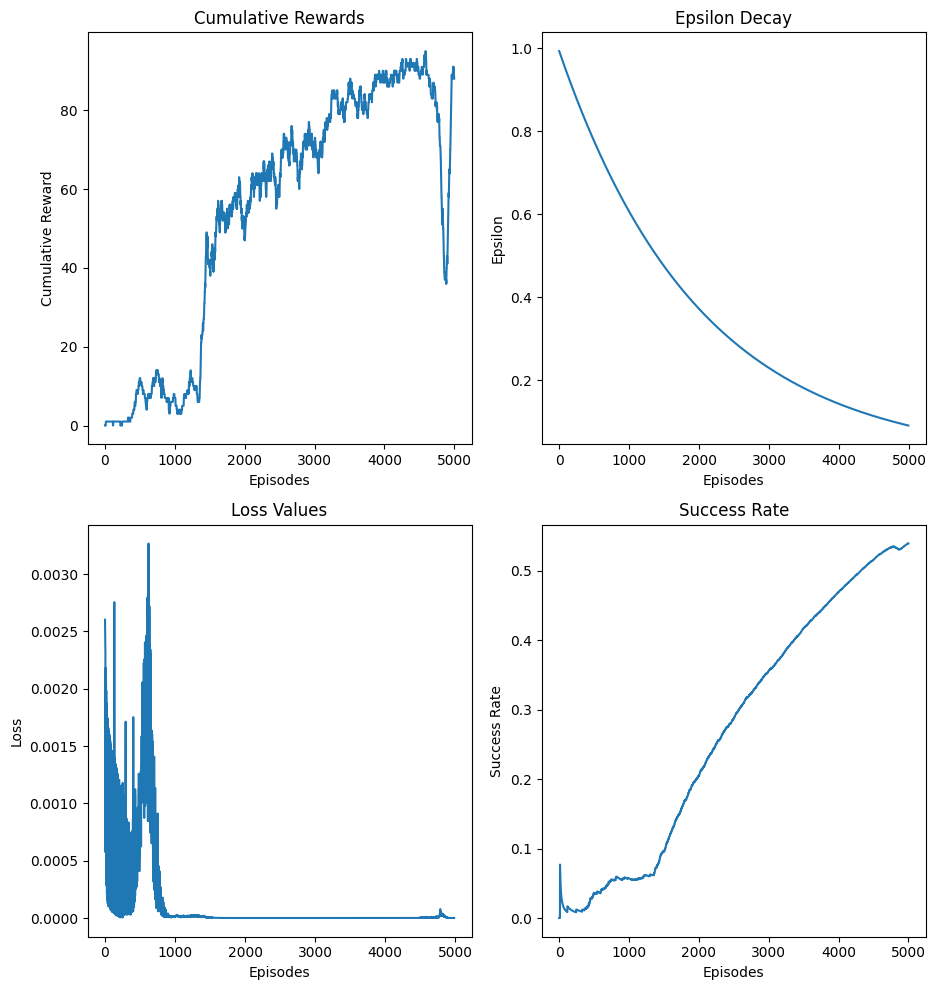

Policy (trained):
00,R,[+0.95 +0.95 +0.96 +0.95] 01,R,[+0.95 +0.00 +0.96 +0.95] 02,D,[+0.96 +0.97 +0.96 +0.96] 03,L,[+0.96 +0.00 +0.95 +0.95] 
04,D,[+0.95 +0.96 +0.00 +0.95] 05,U,[+0.79 +0.73 +0.61 +0.94] 06,D,[+0.00 +0.98 +0.00 +0.96] 07,D,[+0.59 +0.96 +0.31 +0.91] 
08,R,[+0.96 +0.00 +0.97 +0.96] 09,D,[+0.96 +0.98 +0.98 +0.00] 10,D,[+0.97 +0.99 +0.00 +0.97] 11,U,[+0.81 +0.70 +0.52 +0.81] 
12,U,[+0.64 +0.90 +0.83 +1.04] 13,R,[+0.00 +0.98 +0.99 +0.97] 14,R,[+0.98 +0.99 +1.00 +0.98] 15,U,[+0.66 +0.70 +0.56 +0.81] 


In [10]:
if __name__ == '__main__':
    frozen_lake = FrozenLakeDQL()
    is_slippery = False
    frozen_lake.train(5000, is_slippery=is_slippery) 
    frozen_lake.test(10, is_slippery=is_slippery)

Da ich mir nicht sicher war an welcher Stelle die Anzumekren ist: Der Code wurde teilweise von ChatGPT erstellt.
ChatGPT wurde ebenfalls zum debuggen benutzt.